<a href="https://colab.research.google.com/github/pragyan2905/GAN-Augmented-CNN-for-Skin-Lesion-Classification/blob/main/using_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
url = "https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000"
import opendatasets as od
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: qwertypragyan2905
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000


100%|██████████| 5.20G/5.20G [01:57<00:00, 47.6MB/s]

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
DATA_DIR = './skin-cancer-mnist-ham10000/'
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 7
MODEL_SAVE_PATH = 'efficientnet_b0_finetuned.keras'

In [6]:
def load_and_prepare_data(data_dir):

    metadata_path = os.path.join(data_dir, 'HAM10000_metadata.csv')
    df = pd.read_csv(metadata_path)

    image_paths = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_dir, '*', '*.jpg'))}

    df['path'] = df['image_id'].map(image_paths.get)
    df.dropna(subset=['path'], inplace=True)

    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['dx'])
    class_names = label_encoder.classes_

    train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['dx'])
    val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42, stratify=test_val_df['dx'])

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")

    return train_df, val_df, test_df, class_names

In [13]:
def create_data_generators(train_df, val_df, test_df, class_names):
    train_datagen = ImageDataGenerator(
        rescale=1./255.,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255.)
    class_names_list = class_names.tolist()

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df, x_col='path', y_col='dx',
        target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', classes=class_names_list, shuffle=True
    )

    validation_generator = val_test_datagen.flow_from_dataframe(
        dataframe=val_df, x_col='path', y_col='dx',
        target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', classes=class_names_list, shuffle=False
    )

    test_generator = val_test_datagen.flow_from_dataframe(
        dataframe=test_df, x_col='path', y_col='dx',
        target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', classes=class_names_list, shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [8]:
def build_model():

    base_model = EfficientNetB0(
        include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.summary()
    return model, base_model

In [9]:
def train_head(model, train_generator, validation_generator):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max'),
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    ]

    history = model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        callbacks=callbacks
    )
    return history

In [10]:
def fine_tune_model(model, base_model, train_generator, validation_generator):

    base_model.trainable = True
    fine_tune_at = -20

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max'),
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    ]

    history_fine_tune = model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        callbacks=callbacks,
        initial_epoch=model.history.epoch[-1]
    )
    return history_fine_tune

In [11]:
def evaluate_model(model_path, test_generator, class_names):
    best_model = tf.keras.models.load_model(model_path)
    loss, accuracy = best_model.evaluate(test_generator)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    predictions = best_model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    print("\nClassification Report:")
    report = classification_report(true_classes, predicted_classes, target_names=class_names)
    print(report)
    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


Training set size: 7010
Validation set size: 1502
Test set size: 1503
Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,063,658 (15.50 MB)

 Trainable params: 11,527 (45.03 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 196s 761ms/step - accuracy: 0.5113 - loss: 1.6037 - val_accuracy: 0.6698 - val_loss: 1.1334
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 119s 541ms/step - accuracy: 0.6456 - loss: 1.2800 - val_accuracy: 0.6698 - val_loss: 1.1331
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 120s 546ms/step - accuracy: 0.6558 - loss: 1.2387 - val_accuracy: 0.6698 - val_loss: 1.1324
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 119s 541ms/step - accuracy: 0.6480 - loss: 1.2436 - val_accuracy: 0.6698 - val_loss: 1.1285
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 120s 546ms/step - accuracy: 0.6586 - loss: 1.2194 - val_accuracy: 0.6698 - val_loss: 1.1302
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 119s 540ms/step - accuracy: 0.6531 - loss: 1.2202 - val_accuracy: 0.6698 - val_loss: 1.1275
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 170s 657ms/step - accuracy: 0.4987 - loss: 1.7289 - val_accuracy: 0.6698 - val_loss: 1.1798
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 120s 545ms/step - accuracy: 0.5641 -

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


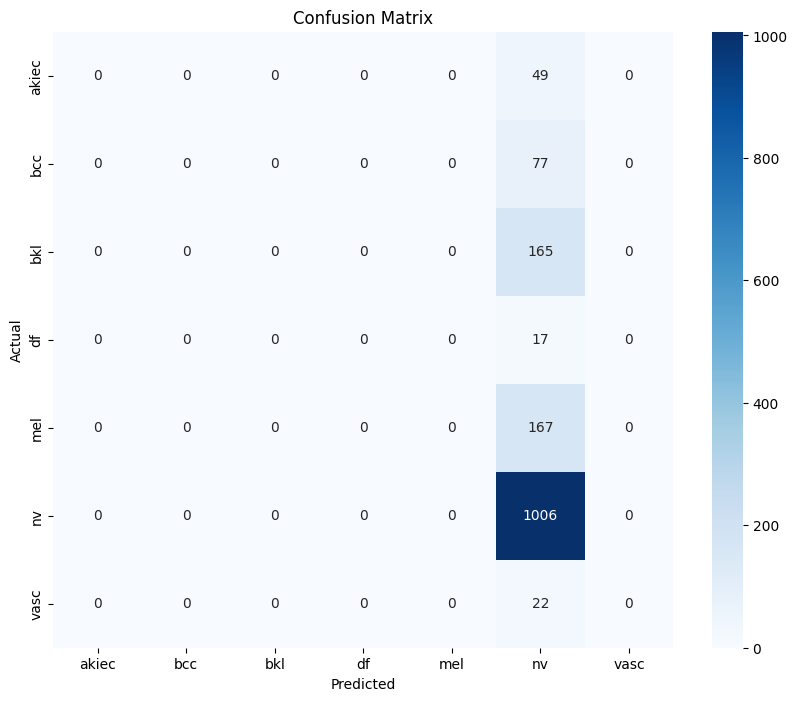

In [14]:
def main():
    train_df, val_df, test_df, class_names = load_and_prepare_data(DATA_DIR)
    train_gen, val_gen, test_gen = create_data_generators(train_df, val_df, test_df, class_names)

    model, base_model = build_model()

    train_head(model, train_gen, val_gen)
    fine_tune_model(model, base_model, train_gen, val_gen)

    evaluate_model(MODEL_SAVE_PATH, test_gen, class_names)

if __name__ == '__main__':
    main()



In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

DRIVE_PROJECT_DIR = '/content/drive/MyDrive/Skin_Cancer_Finetune/'
MODEL_SAVE_PATH = os.path.join(DRIVE_PROJECT_DIR, 'efficientnet_b0_finetuned.keras')
LOCAL_MODEL_PATH = 'efficientnet_b0_finetuned.keras'

os.makedirs(DRIVE_PROJECT_DIR, exist_ok=True)

model = load_model(LOCAL_MODEL_PATH)
model.save(MODEL_SAVE_PATH)